# **Georg Feiler**
## **Ноутбук к магистерской диссертации**
###
### **Тема:**
### **"Разработка моделей машинного обучения для предсказания выживаемости после трансплантации стволовых клеток"**
## 


## **Шаг 1. Импорт библиотек**

In [4]:
import numpy as np
import pandas as pd
import pandas.api.types
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from lifelines.utils import concordance_index
from collections import defaultdict


## **Шаг 2. Установка метрики соревнований**

In [6]:
"""
To evaluate the equitable prediction of transplant survival outcomes,
we use the concordance index (C-index) between a series of event
times and a predicted score across each race group.
 
It represents the global assessment of the model discrimination power:
this is the model’s ability to correctly provide a reliable ranking
of the survival times based on the individual risk scores.
 
The concordance index is a value between 0 and 1 where:
 
0.5 is the expected result from random predictions,
1.0 is perfect concordance (with no censoring, otherwise <1.0),
0.0 is perfect anti-concordance (with no censoring, otherwise >0.0)

"""


class ParticipantVisibleError(Exception):
    pass


def score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str) -> float:
    """
    >>> import pandas as pd
    >>> row_id_column_name = "id"
    >>> y_pred = {'prediction': {0: 1.0, 1: 0.0, 2: 1.0}}
    >>> y_pred = pd.DataFrame(y_pred)
    >>> y_pred.insert(0, row_id_column_name, range(len(y_pred)))
    >>> y_true = { 'efs': {0: 1.0, 1: 0.0, 2: 0.0}, 'efs_time': {0: 25.1234,1: 250.1234,2: 2500.1234}, 'race_group': {0: 'race_group_1', 1: 'race_group_1', 2: 'race_group_1'}}
    >>> y_true = pd.DataFrame(y_true)
    >>> y_true.insert(0, row_id_column_name, range(len(y_true)))
    >>> score(y_true.copy(), y_pred.copy(), row_id_column_name)
    0.75
    """
    
    del solution[row_id_column_name]
    del submission[row_id_column_name]
    
    event_label = 'efs'
    interval_label = 'efs_time'
    prediction_label = 'prediction'
    for col in submission.columns:
        if not pandas.api.types.is_numeric_dtype(submission[col]):
            raise ParticipantVisibleError(f'Submission column {col} must be a number')
    # Merging solution and submission dfs on ID
    merged_df = pd.concat([solution, submission], axis=1)
    merged_df.reset_index(inplace=True)
    merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)
    metric_list = []
    for race in merged_df_race_dict.keys():
        # Retrieving values from y_test based on index
        indices = sorted(merged_df_race_dict[race])
        merged_df_race = merged_df.iloc[indices]
        # Calculate the concordance index
        c_index_race = concordance_index(
                        merged_df_race[interval_label],
                        -merged_df_race[prediction_label],
                        merged_df_race[event_label])
        metric_list.append(c_index_race)
    return float(np.mean(metric_list)-np.sqrt(np.var(metric_list)))


## **Шаг 3. Загрузка и подготовка данных**

In [8]:
# Загрузка полного train.csv
train_full = pd.read_csv("train.csv")

# Сохраняем колонку с расой
race_group_col = train_full[['ID', 'race_group']].copy()

# Делим данные на train, validation и test с сохранением пропорции расовых групп
train_val, test = train_test_split(train_full, test_size=0.15, random_state=42, stratify=train_full['race_group'])
train, val = train_test_split(train_val, test_size=0.15, random_state=42, stratify=train_val['race_group'])

# Добавляем метки источника для объединения и последующего разделения
train['source'] = 'train'
val['source'] = 'val'
test['source'] = 'test'

# Объединяем для единой предобработки
full_data = pd.concat([train, val, test], axis=0).reset_index(drop=True)

# Проверка данных
print("Train data shape:", train.shape)
print("Val data shape:", val.shape)
print("Test data shape:", test.shape)


Train data shape: (20808, 61)
Val data shape: (3672, 61)
Test data shape: (4320, 61)


### **Проверим датасет на сбалансированность по расовым группам**

In [180]:
print("Размер полного датасета:", train_full.shape)
counts = train_full['race_group'].value_counts()
print(counts)


Размер полного датасета: (28800, 60)
race_group
More than one race                           4845
Asian                                        4832
White                                        4831
Black or African-American                    4795
American Indian or Alaska Native             4790
Native Hawaiian or other Pacific Islander    4707
Name: count, dtype: int64


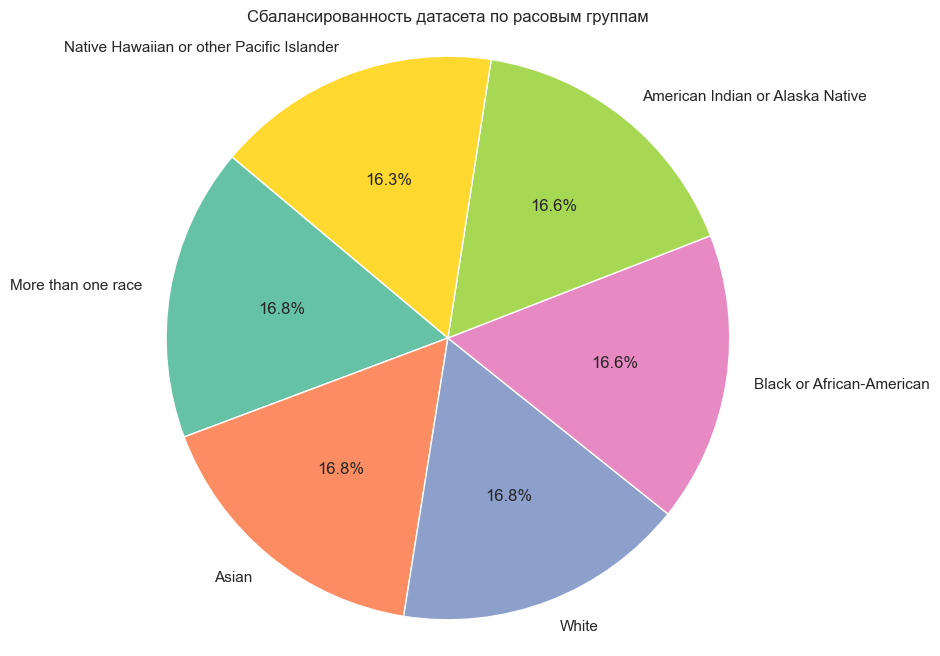

In [196]:
# Названия групп
labels = ['More than one race', 'Asian', 'White', 'Black or African-American', 
          'American Indian or Alaska Native', 'Native Hawaiian or other Pacific Islander']

# Цветовая палитра
colors = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854', '#ffd92f']

# Построение диаграммы
plt.figure(figsize=(8, 8))
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
plt.axis('equal')  # Делает круг правильным
plt.title("Сбалансированность датасета по расовым группам")
plt.show()


## **Шаг 4. Предобработка данных**

In [10]:
# Сохраняем колонку с расой до преобразований
race_group_col_all = full_data[['ID', 'race_group']].copy()

# Отделяем метку источника
source_col = full_data['source']
full_data = full_data.drop(columns=['source'])


In [11]:
# Определяем числовые и категориальные признаки
cat_cols = full_data.select_dtypes(include='object').columns
num_cols = full_data.select_dtypes(include=['float64', 'int64']).drop(columns=['efs', 'efs_time'], errors='ignore').columns

# Заполняем пропущенные значения: числовые — медианой, категориальные — модой
full_data[num_cols] = full_data[num_cols].fillna(full_data[num_cols].median())
for col in cat_cols:
    full_data[col] = full_data[col].fillna(full_data[col].mode()[0])

print("Заполнение прорусков завершено!")


Заполнение прорусков завершено!


In [12]:
# One-hot кодируем категориальные признаки
full_data = pd.get_dummies(full_data, columns=cat_cols, drop_first=True)

# И снова добавляем метку источника
full_data['source'] = source_col


In [13]:
# Разделяем обратно на подмножества
train = full_data[full_data['source'] == 'train'].drop(columns='source')
val = full_data[full_data['source'] == 'val'].drop(columns='source')
test = full_data[full_data['source'] == 'test'].drop(columns='source')


## **Шаг 5. Подготовка целевых переменных и признаков**

In [15]:
# Формируем X и y для train, val, test
X_train = train.drop(columns=['efs', 'efs_time', 'ID'])
y_train_clf = train['efs'].astype(int)
y_train_reg = train['efs_time']

X_val = val.drop(columns=['efs', 'efs_time', 'ID'])
y_val_clf = val['efs'].astype(int)
y_val_reg = val['efs_time']

X_test = test.drop(columns=['efs', 'efs_time', 'ID'])
y_test_clf = test['efs'].astype(int)
y_test_reg = test['efs_time']

print("Формирование признаков и целевых переменных завершено!")


Формирование признаков и целевых переменных завершено!


In [16]:
# После завершения всех этапов подготовки X_test
X_test_preprocessed = X_test.copy()
X_test_preprocessed['ID'] = test['ID'].values

# Сохраняем
X_test_preprocessed.to_csv("X_test_preprocessed.csv", index=False)


### **Вывод признаков**

In [18]:
X = X_train.copy()
print(X.columns.tolist())


['hla_match_c_high', 'hla_high_res_8', 'hla_low_res_6', 'hla_high_res_6', 'hla_high_res_10', 'hla_match_dqb1_high', 'hla_nmdp_6', 'hla_match_c_low', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'year_hct', 'hla_match_a_high', 'donor_age', 'hla_match_b_low', 'age_at_hct', 'hla_match_a_low', 'hla_match_b_high', 'comorbidity_score', 'karnofsky_score', 'hla_low_res_8', 'hla_match_drb1_high', 'hla_low_res_10', 'dri_score_High - TED AML case <missing cytogenetics', 'dri_score_Intermediate', 'dri_score_Intermediate - TED AML case <missing cytogenetics', 'dri_score_Low', 'dri_score_Missing disease status', 'dri_score_N/A - disease not classifiable', 'dri_score_N/A - non-malignant indication', 'dri_score_N/A - pediatric', 'dri_score_TBD cytogenetics', 'dri_score_Very high', 'psych_disturb_Not done', 'psych_disturb_Yes', 'cyto_score_Intermediate', 'cyto_score_Normal', 'cyto_score_Not tested', 'cyto_score_Other', 'cyto_score_Poor', 'cyto_score_TBD', 'diabetes_Not done', 'diabetes_Yes', 'tbi_status

In [19]:
# Выводим расовые колонки как отдельную группу
race_columns = race_group_col['race_group'].unique()

for race in race_columns:
    print(race)


More than one race
Asian
White
American Indian or Alaska Native
Native Hawaiian or other Pacific Islander
Black or African-American


In [20]:
# race_columns — те, что реально присутствуют в признаках
race_columns = [col for col in X.columns if col.startswith('race_group_')]

for race in race_columns:
    print(race)


race_group_Asian
race_group_Black or African-American
race_group_More than one race
race_group_Native Hawaiian or other Pacific Islander
race_group_White


In [21]:
# Добавим базовую категорию вручную
race_columns.append('race_group_American Indian or Alaska Native')

for race in race_columns:
    print(race)


race_group_Asian
race_group_Black or African-American
race_group_More than one race
race_group_Native Hawaiian or other Pacific Islander
race_group_White
race_group_American Indian or Alaska Native


## **Шаг 6. Группировка признаков по тематике**

In [23]:
# Группировка признаков
all_features = [col for col in X.columns]

groups = {
    'all_features': all_features
}

print("Группировка признаков завершена!")


Группировка признаков завершена!


In [24]:
# Добавляем группу со всеми признаками кроме признаков расовой принадлежности
groups['no_race_features'] = [col for col in groups['all_features'] if col not in race_columns]

print("Группа 'no_race_features' добавлена в словарь!")


Группа 'no_race_features' добавлена в словарь!


In [25]:
#Проверяем наличие всех групп в словаре
groups.keys()


dict_keys(['all_features', 'no_race_features'])

In [26]:
# Проверим количество признаков в группах
for group_name, feature_list in groups.items():
    print(f"\nНазвание группы: {group_name}, количество признаков = {len(feature_list)}")



Название группы: all_features, количество признаков = 148

Название группы: no_race_features, количество признаков = 143


In [27]:
# Параметры для ручной настройки (редактируем здесь)
manual_params_by_group = {
    'all_features':      {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_leaf': 4, 'n_estimators': 800},
    'no_race_features':      {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_leaf': 4, 'n_estimators': 800}
}


print("Найденные лучшие гиперпараметры подставлены!")



Найденные лучшие гиперпараметры подставлены!


## **Шаг 7. Обучение двухэтапных моделей и получение предсказаний**

In [29]:
# Словари для хранения моделей и предсказаний
manual_group_models_reg = {}  # регрессионные модели по группам
manual_group_models_clf = {}  # классификаторы по группам
meta_preds_val_two_stage = []  # финальные предсказания на валидации
meta_preds_test_two_stage = []  # финальные предсказания на тесте
val_scores_summary = []  # сводка метрик для валидации
test_scores_summary = []  # сводка метрик для теста

# Обучение по каждой тематической группе признаков
for name, params in manual_params_by_group.items():
    # Выбор признаков для текущей группы
    X_tr = X_train[groups[name]]
    X_va = X_val[groups[name]]
    X_te = X_test[groups[name]]

    # Классификатор событий: вероятность наступления события (efs=1)
    clf = GradientBoostingClassifier(
        learning_rate=0.035,
        max_depth=5,
        max_features='sqrt',
        min_samples_leaf=4,
        min_samples_split=2,
        n_estimators=850,
        subsample=0.85,
        random_state=42
    )
    clf.fit(X_tr, y_train_clf)
    p_event_val = clf.predict_proba(X_va)[:, 1]  # вероятность события на валидации
    p_event_test = clf.predict_proba(X_te)[:, 1]  # вероятность события на тесте

    # Регрессор времени: прогнозирует log(время до события), только для efs==1
    reg = GradientBoostingRegressor(**params)
    reg.fit(X_tr[y_train_clf == 1], np.log1p(y_train_reg[y_train_clf == 1]))
    pred_val_gbm = np.expm1(reg.predict(X_va[y_val_clf == 1]))
    pred_test_gbm = np.expm1(reg.predict(X_te))

    # Альтернативный регрессор: нейросетевая модель LSTM
    # Стандартизация данных
    scaler = StandardScaler()
    X_lstm_tr = scaler.fit_transform(X_tr[y_train_clf == 1])
    X_lstm_va = scaler.transform(X_va[y_val_clf == 1])
    X_lstm_te = scaler.transform(X_te)

    # Преобразование под формат [samples, timesteps, features] для LSTM
    X_lstm_tr = X_lstm_tr.reshape((-1, 1, X_lstm_tr.shape[1]))
    X_lstm_va = X_lstm_va.reshape((-1, 1, X_lstm_va.shape[1]))
    X_lstm_te = X_lstm_te.reshape((-1, 1, X_lstm_te.shape[1]))

    # Построение LSTM-сети
    lstm = Sequential([
        Input(shape=(1, X_lstm_tr.shape[2])),
        LSTM(64, return_sequences=False),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    lstm.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    lstm.fit(X_lstm_tr, np.log1p(y_train_reg[y_train_clf == 1]), epochs=10, batch_size=32, verbose=0)

    # Предсказания регрессора на валидации и тесте
    pred_val_lstm = np.expm1(lstm.predict(X_lstm_va, verbose=0).flatten())
    pred_test_lstm = np.expm1(lstm.predict(X_lstm_te, verbose=0).flatten())

    # Объединение предсказаний двух регрессоров
    pred_val = 0.69 * pred_val_gbm + 0.31 * pred_val_lstm
    pred_test = 0.69 * pred_test_gbm + 0.31 * pred_test_lstm

    # Финальное значение: вероятность события * преобразованное время
    # Модифицированная формула риска
    # Используем сигмоидальную функцию для масштабирования предсказанного времени — 
    # она снижает влияние выбросов и превращает значение в диапазон (0, 1),
    # после чего используется как поправочный коэффициент при расчёте риска
    final_val = p_event_val[y_val_clf == 1] * (1 / (1 + np.exp(2.2 * pred_val)))
    final_test = p_event_test * (1 / (1 + np.exp(2.2 * pred_test)))

    # Сохраняем обученные модели
    manual_group_models_clf[name] = clf
    manual_group_models_reg[name] = reg
    
    # Добавляем в стек предсказаний
    meta_preds_val_two_stage.append(final_val)
    meta_preds_test_two_stage.append(final_test)

    # Оценка качества на валидации
    val_ids = y_val_clf[y_val_clf == 1].index
    val_copy = val.copy()
    val_copy['prediction'] = np.nan
    val_copy.loc[val_ids, 'prediction'] = final_val
    val_copy['race_group'] = val_copy['ID'].map(race_group_col.set_index('ID')['race_group'])
    val_clean = val_copy.dropna(subset=['prediction'])
    submission_val = val_clean[['ID', 'prediction']].copy()
    
    # Метрики качества на валидации
    c_idx_val = concordance_index(1 - val_clean['efs_time'].values, val_clean['prediction'].values, val_clean['efs'].values)
    cv_val = score(val_clean[['ID', 'efs', 'efs_time', 'race_group']].copy(), submission_val.copy(), 'ID')

    # Аналогично для теста
    test_ids = y_test_clf[y_test_clf == 1].index
    test_df = test.loc[test_ids, ['ID', 'efs', 'efs_time']].copy()
    test_df['race_group'] = test_df['ID'].map(race_group_col.set_index('ID')['race_group'])
    final_test_series = pd.Series(final_test, index=X_test.index)
    final_test_subset = final_test_series.loc[test_ids].values
    test_df['prediction'] = final_test_subset
    test_df.dropna(subset=['efs', 'efs_time', 'race_group', 'prediction'], inplace=True)
    submission_test = test_df[['ID', 'prediction']].copy()
    
    # Метрики качества на тесте
    c_idx_test = concordance_index(1 - test_df['efs_time'].values, test_df['prediction'].values, test_df['efs'].values)
    cv_test = score(test_df[['ID', 'efs', 'efs_time', 'race_group']].copy(), submission_test.copy(), 'ID')

    # Сохраняем метрики
    val_scores_summary.append({'Группа': name, 'C-Index (val)': c_idx_val, 'CV Score (val)': cv_val})
    test_scores_summary.append({'Группа': name, 'C-Index (test)': c_idx_test, 'CV Score (test)': cv_test})
    
    print(f"Группа '{name}' успешно обучена. Предсказание сделано для {len(final_test)} тестовых образцов.")


Группа 'all_features' успешно обучена. Предсказание сделано для 4320 тестовых образцов.
Группа 'no_race_features' успешно обучена. Предсказание сделано для 4320 тестовых образцов.



Результаты на валидационной выборке:
             Группа  C-Index (val)  CV Score (val)
0      all_features       0.699299        0.682050
1  no_race_features       0.696518        0.680932

Результаты на тестовой выборке:
             Группа  C-Index (test)  CV Score (test)
0      all_features        0.708798         0.688085
1  no_race_features        0.705594         0.688069


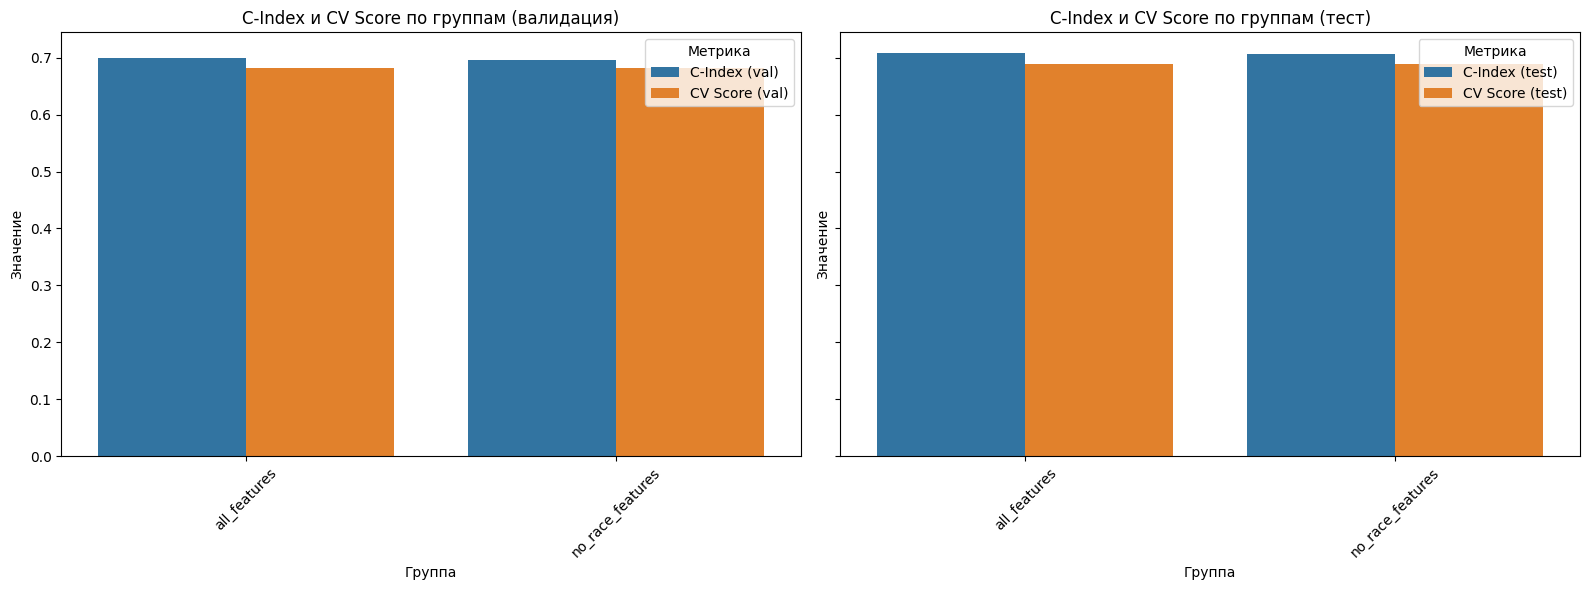

In [30]:
# Смотрим на результаты на валидационной и тестовой выборке
val_df_summary = pd.DataFrame(val_scores_summary)
test_df_summary = pd.DataFrame(test_scores_summary)

print("\nРезультаты на валидационной выборке:")
print(val_df_summary.sort_values(by='C-Index (val)', ascending=False))

print("\nРезультаты на тестовой выборке:")
print(test_df_summary.sort_values(by='C-Index (test)', ascending=False))

# Подготовка данных для объединённого barplot
val_melted = val_df_summary.melt(id_vars='Группа', var_name='Метрика', value_name='Значение')
test_melted = test_df_summary.melt(id_vars='Группа', var_name='Метрика', value_name='Значение')

# Объединённая визуализация barplot по C-Index и CV Score
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
sns.barplot(data=val_melted, x='Группа', y='Значение', hue='Метрика', ax=axes[0])
axes[0].set_title('C-Index и CV Score по группам (валидация)')
axes[0].tick_params(axis='x', rotation=45)

sns.barplot(data=test_melted, x='Группа', y='Значение', hue='Метрика', ax=axes[1])
axes[1].set_title('C-Index и CV Score по группам (тест)')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


## **Шаг 8. Настройка весов и финальное объединение предсказаний**

In [32]:
# Веса групп
group_weights = {
    'all_features': 0.8,
    'no_race_features': 0.2
}

# Объединение предсказаний по весам
ensemble_pred_val = np.sum([
    group_weights[name] * meta_preds_val_two_stage[i] for i, name in enumerate(groups.keys())
], axis=0)

ensemble_pred_test = np.sum([
    group_weights[name] * meta_preds_test_two_stage[i] for i, name in enumerate(groups.keys())
], axis=0)

print("Веса настроены и предсказания объединены!")


Веса настроены и предсказания объединены!


## **Шаг 9. Заключительная проверка модели на тестовой выборке**

C-Index на тестовой выборке (efs==1): 0.70915
CV Score (custom metric) на тестовой выборке: 0.70027

C-Index по расовым группам на тестовой выборке:
                                  Race Group   C-Index
1                  Black or African-American  0.721996
3                                      White  0.716440
4  Native Hawaiian or other Pacific Islander  0.707649
5           American Indian or Alaska Native  0.704573
0                         More than one race  0.704387
2                                      Asian  0.696655

C-Index на валидационной выборке (efs==1): 0.70044
CV Score (custom metric) на валидационной выборке: 0.68320

C-Index по расовым группам на валидационной выборке:
                                  Race Group   C-Index
1                         More than one race  0.724139
2                                      Asian  0.712759
0                                      White  0.705780
5  Native Hawaiian or other Pacific Islander  0.700405
3                  Black o

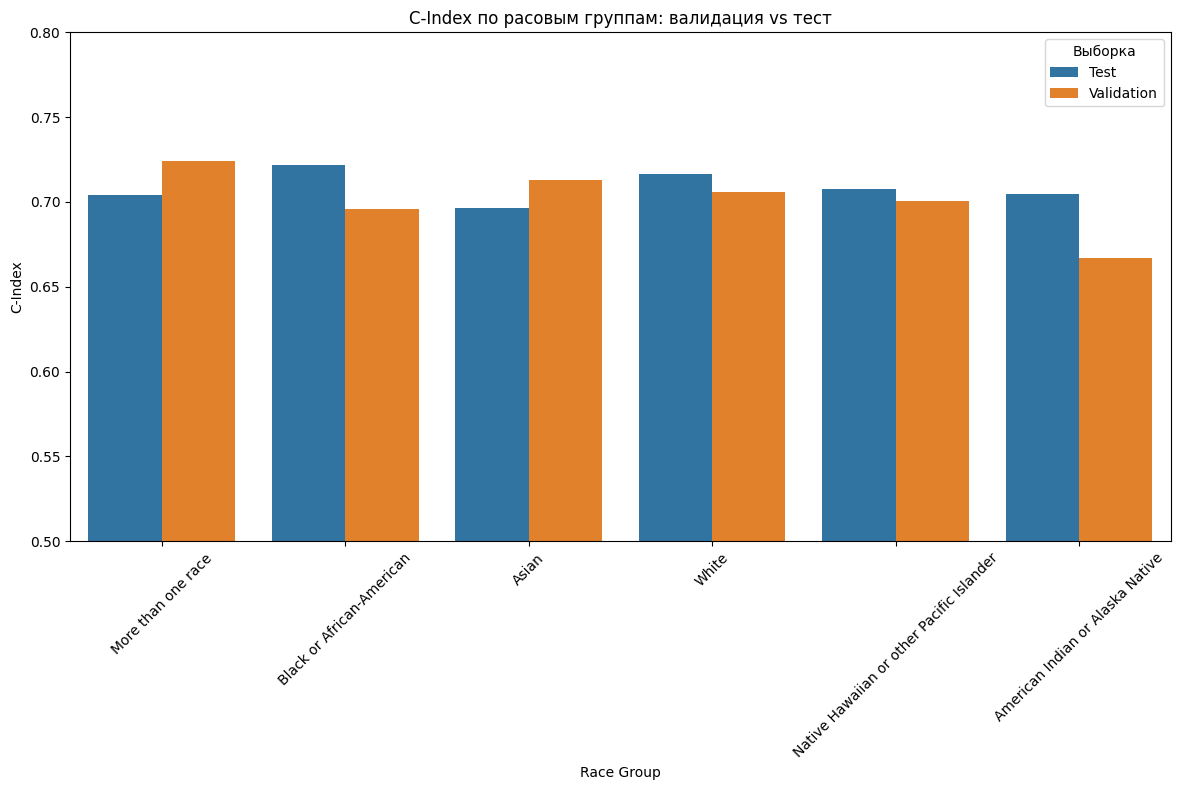

In [34]:
# --- TEST SET ---

# Отбираем только наблюдаемые события (efs == 1)
test_mask = y_test_clf == 1

# Расчёт C-Index на полной тестовой выборке по наблюдаемым событиям
c_index_test = concordance_index(
    1 - y_test_reg[test_mask].values,
    ensemble_pred_test[test_mask],
    y_test_clf[test_mask].values
)
print(f"C-Index на тестовой выборке (efs==1): {c_index_test:.5f}")

# Подготовка датафреймов для кастомной метрики (CV Score)
test_ids = test[test_mask].index
race_group_test = race_group_col.set_index('ID').loc[test_ids, 'race_group']

# Формируем таблицу истинных значений и предсказаний
y_true_test = pd.DataFrame({
    'ID': test_ids,
    'efs': y_test_clf[test_mask].values,
    'efs_time': y_test_reg[test_mask].values,
    'race_group': race_group_test.values,
    'prediction': ensemble_pred_test[test_mask]
})
y_pred_test = y_true_test[['ID', 'prediction']].copy()

# Расчёт CV Score — с учётом стратификации по расовым группам
cv_score_test = score(
    y_true_test[['ID', 'efs', 'efs_time', 'race_group']].copy(),
    y_pred_test.copy(),
    'ID'
)
print(f"CV Score (custom metric) на тестовой выборке: {cv_score_test:.5f}")

# Расчёт C-Index отдельно по каждой расовой группе
race_c_idx_test = {}
for race in y_true_test['race_group'].unique():
    mask = y_true_test['race_group'] == race
    c_idx = concordance_index(
        1 - y_true_test.loc[mask, 'efs_time'].values,
        y_true_test.loc[mask, 'prediction'].values,
        y_true_test.loc[mask, 'efs'].values
    )
    race_c_idx_test[race] = c_idx


# Формируем таблицу с результатами по расам
race_c_idx_test_df = pd.DataFrame(list(race_c_idx_test.items()), columns=['Race Group', 'C-Index'])
print("\nC-Index по расовым группам на тестовой выборке:")
print(race_c_idx_test_df.sort_values(by='C-Index', ascending=False))  
print('')


# --- VALIDATION SET ---

# Отбираем только наблюдаемые события (efs == 1)
val_mask = y_val_clf == 1

# Подготовка датафреймов для кастомной метрики (CV Score)
val_ids = y_val_clf[val_mask].index
race_group_val = race_group_col.set_index('ID').loc[val_ids, 'race_group']

# Формируем таблицу истинных значений и предсказаний
y_true_val = pd.DataFrame({
    'ID': val_ids,
    'efs': y_val_clf[val_mask].values,
    'efs_time': y_val_reg[val_mask].values,
    'race_group': race_group_val.values,
    'prediction': ensemble_pred_val  # Уже отфильтровано по efs==1
})
y_pred_val = y_true_val[['ID', 'prediction']].copy()

# Расчёт C-Index на полной валидационной выборке по наблюдаемым событиям
c_index_val = concordance_index(
    1 - y_true_val['efs_time'].values,
    y_true_val['prediction'].values,
    y_true_val['efs'].values
)
print(f"C-Index на валидационной выборке (efs==1): {c_index_val:.5f}")

# Расчёт CV Score — с учётом стратификации по расовым группам
cv_score_val = score(
    y_true_val[['ID', 'efs', 'efs_time', 'race_group']].copy(),
    y_pred_val.copy(),
    'ID'
)
print(f"CV Score (custom metric) на валидационной выборке: {cv_score_val:.5f}")

race_c_idx_val = {}
for race in y_true_val['race_group'].unique():
    mask = y_true_val['race_group'] == race
    c_idx = concordance_index(
        1 - y_true_val.loc[mask, 'efs_time'].values,
        y_true_val.loc[mask, 'prediction'].values,
        y_true_val.loc[mask, 'efs'].values
    )
    race_c_idx_val[race] = c_idx


# Формируем таблицу с результатами по расам
race_c_idx_val_df = pd.DataFrame(list(race_c_idx_val.items()), columns=['Race Group', 'C-Index'])
print("\nC-Index по расовым группам на валидационной выборке:")
print(race_c_idx_val_df.sort_values(by='C-Index', ascending=False))

# --- ВИЗУАЛИЗАЦИЯ СРАВНЕНИЯ ПО РАСАМ ---

df_plot = pd.DataFrame([
    {'Race Group': race, 'C-Index': score, 'Dataset': 'Test'}
    for race, score in race_c_idx_test.items()
] + [
    {'Race Group': race, 'C-Index': race_c_idx_val[race], 'Dataset': 'Validation'}
    for race in race_c_idx_val
])

plt.figure(figsize=(12, 8))
sns.barplot(data=df_plot, x='Race Group', y='C-Index', hue='Dataset')
plt.xticks(rotation=45)
plt.ylim(0.5, 0.8)
plt.title("C-Index по расовым группам: валидация vs тест")
plt.ylabel("C-Index")
plt.xlabel("Race Group")
plt.legend(title='Выборка')
plt.tight_layout()
plt.show()


## **Шаг 10. Доверительный интервал для C-Index и CV Score**

In [36]:
# Функция для оценки доверительного интервала метрики через бутстрэп
def bootstrap_ci_df(metric_fn, df, n_iterations=1000, alpha=0.05):
    metrics = []
    n = len(df)
    
    for _ in range(n_iterations):
        indices = np.random.choice(n, n, replace=True)
        df_sample = df.iloc[indices]
        score = metric_fn(df_sample)
        metrics.append(score)
        
    # Вычисляем доверительный интервал (здесь 95%) по процентилям    
    lower = np.percentile(metrics, 100 * alpha / 2)
    upper = np.percentile(metrics, 100 * (1 - alpha / 2))
    return np.mean(metrics), (lower, upper)


In [37]:
# Функция для расчёта C-Index (Harrell's Concordance Index)
def metric_fn_ci(df_sample):
    return concordance_index(
        1 - df_sample['efs_time'].values,
        df_sample['prediction'].values,
        df_sample['efs'].values
    )

# Вызов расчёта CI для C-Index на тесте и валидации
mean_cidx_test, ci_cidx_test = bootstrap_ci_df(metric_fn_ci, y_true_test)
mean_cidx_val, ci_cidx_val = bootstrap_ci_df(metric_fn_ci, y_true_val)

print(f"C-Index (Test): {mean_cidx_test:.3f} [{ci_cidx_test[0]:.3f} – {ci_cidx_test[1]:.3f}]")
print(f"C-Index (Val): {mean_cidx_val:.3f} [{ci_cidx_val[0]:.3f} – {ci_cidx_val[1]:.3f}]")


C-Index (Test): 0.709 [0.698 – 0.721]
C-Index (Val): 0.701 [0.687 – 0.714]


In [38]:
# Функция для расчёта CV Score (custom fairness-aware score)
def metric_fn_cv(df_sample):
    y_true_df = df_sample[['ID', 'efs', 'efs_time', 'race_group']].copy()
    y_pred_df = df_sample[['ID', 'prediction']].copy()
    return score(y_true_df, y_pred_df, row_id_column_name='ID')

# Вызов расчёта CI для CV Score на тесте и валидации
mean_cv_test, ci_cv_test = bootstrap_ci_df(metric_fn_cv, y_true_test)
mean_cv_val, ci_cv_val = bootstrap_ci_df(metric_fn_cv, y_true_val)

print(f"CV Score (Test): {mean_cv_test:.3f} [{ci_cv_test[0]:.3f} – {ci_cv_test[1]:.3f}]")
print(f"CV Score (Val): {mean_cv_val:.3f} [{ci_cv_val[0]:.3f} – {ci_cv_test[1]:.3f}]")


CV Score (Test): 0.694 [0.679 – 0.708]
CV Score (Val): 0.678 [0.660 – 0.708]


In [39]:
# Собираем всё в таблицу
ci_summary_df = pd.DataFrame([
    {
        "Метрика": "C-Index",
        "Выборка": "Тест",
        "Среднее значение": f"{mean_cidx_test:.3f}",
        "95% дов. интервал": f"[{ci_cidx_test[0]:.3f} – {ci_cidx_test[1]:.3f}]"
    },
    {
        "Метрика": "CV Score",
        "Выборка": "Тест",
        "Среднее значение": f"{mean_cv_test:.3f}",
        "95% дов. интервал": f"[{ci_cv_test[0]:.3f} – {ci_cv_test[1]:.3f}]"
    },
    {
        "Метрика": "C-Index",
        "Выборка": "Валидация",
        "Среднее значение": f"{mean_cidx_val:.3f}",
        "95% дов. интервал": f"[{ci_cidx_val[0]:.3f} – {ci_cidx_val[1]:.3f}]"
    },
    {
        "Метрика": "CV Score",
        "Выборка": "Валидация",
        "Среднее значение": f"{mean_cv_val:.3f}",
        "95% дов. интервал": f"[{ci_cv_val[0]:.3f} – {ci_cv_val[1]:.3f}]"
    },
])

# Отображение
import IPython.display as disp
disp.display(ci_summary_df)


,Метрика,Выборка,Среднее значение,95% дов. интервал
0,C-Index,Тест,0.709,[0.698 – 0.721]
1,CV Score,Тест,0.694,[0.679 – 0.708]
2,C-Index,Валидация,0.701,[0.687 – 0.714]
3,CV Score,Валидация,0.678,[0.660 – 0.696]


## **Шаг 11. Возврат предсказаний по тестовой выборке в виде таблицы**

In [42]:
# Возврат расширенных предсказаний по тестовой выборке в виде таблицы по убыванию risk_score
test_pred_df = test[['ID']].copy()
test_pred_df = test_pred_df.loc[y_test_clf == 1].copy()

# Сопоставляем только наблюдаемые предсказания
test_pred_df['p_event'] = p_event_test[y_test_clf == 1]
test_pred_df['pred_time'] = pred_test[y_test_clf == 1]
test_pred_df['risk_score'] = ensemble_pred_test[y_test_clf == 1]

# Пояснение:
# - p_event — вероятность наступления события (например, смерти/рецидива)
# - pred_time — условное прогнозируемое время до события (в днях)
# - risk_score — итоговый риск-скор, по которому модель ранжирует пациентов
# Чем ниже значение risk_score — тем благоприятнее прогноз. Он не является ни временем, ни вероятностью напрямую.

# Сортировка по ID и добавление порядкового номера
test_pred_df = test_pred_df.sort_values(by='risk_score', ascending=False).reset_index(drop=True)
test_pred_df.index = test_pred_df.index + 1
test_pred_df.index.name = '№'

# Сохраняем в CSV
test_pred_df.to_csv("test_predictions_full.csv", index=True)

print("Полные предсказания сохранены в test_predictions_full.csv")
print(test_pred_df.head())


Полные предсказания сохранены в test_predictions_full.csv
      ID   p_event  pred_time  risk_score
№                                        
1  22905  0.739733   2.016094    0.014907
2  28050  0.884433   2.111845    0.011650
3  17657  0.908632   2.226841    0.005968
4   9975  0.713561   2.225970    0.005868
5  21242  0.887267   2.443932    0.005416


In [43]:
# Возврат расширенных предсказаний по тестовой выборке в виде таблицы по убыванию pred_time
test_pred_df_time = test[['ID']].copy()
test_pred_df_time = test_pred_df_time.loc[y_test_clf == 1].copy()

# Сопоставляем только наблюдаемые предсказания
test_pred_df_time['p_event'] = p_event_test[y_test_clf == 1]
test_pred_df_time['pred_time'] = pred_test[y_test_clf == 1]
test_pred_df_time['risk_score'] = ensemble_pred_test[y_test_clf == 1]

# Пояснение:
# - p_event — вероятность наступления события (например, смерти/рецидива)
# - pred_time — условное прогнозируемое время до события (в днях)
# - risk_score — итоговый риск-скор, по которому модель ранжирует пациентов
# Чем ниже значение risk_score — тем благоприятнее прогноз. Он не является ни временем, ни вероятностью напрямую.

# Сортировка по ID и добавление порядкового номера
test_pred_df_time = test_pred_df_time.sort_values(by='pred_time', ascending=False).reset_index(drop=True)
test_pred_df_time.index = test_pred_df_time.index + 1
test_pred_df_time.index.name = '№'

# Сохраняем в CSV
test_pred_df_time.to_csv("test_predictions_full_time.csv", index=True)

print("Полные предсказания сохранены в test_predictions_full.csv")
print(test_pred_df_time.head())


Полные предсказания сохранены в test_predictions_full.csv
      ID   p_event  pred_time    risk_score
№                                          
1   5555  0.599268  11.350393  2.292828e-10
2   6319  0.626689  10.684200  1.844310e-10
3   9012  0.714126  10.116080  1.153436e-10
4   8072  0.830787  10.037690  2.904770e-10
5  20654  0.723756   9.922068  6.750206e-11


### **Приводим pred_time к диапазону efs_time обучающей выборки:**

In [45]:
# Используем min/max по обучающей выборке efs_time
train_times = train[train['efs'] == 1]['efs_time']

# Минимальное и максимальное время до события в обучении
t_min = train_times.min()
t_max = train_times.max()

# Масштабируем pred_time из текущего диапазона [pred_min, pred_max] → [t_min, t_max]
pred_min = pred_test.min()
pred_max = pred_test.max()

# Линейная трансформация
pred_time_scaled = (pred_test - pred_min) / (pred_max - pred_min)
pred_time_days = pred_time_scaled * (t_max - t_min) + t_min


In [46]:
# Возврат расширенных предсказаний по тестовой выборке в виде таблицы по убыванию pred_time
test_pred_df_time = test[['ID']].copy()
test_pred_df_time = test_pred_df_time.loc[y_test_clf == 1].copy()

# Сопоставляем только наблюдаемые предсказания
test_pred_df_time['p_event'] = p_event_test[y_test_clf == 1]
test_pred_df_time['pred_time'] = pred_time_days[y_test_clf == 1]
test_pred_df_time['risk_score'] = ensemble_pred_test[y_test_clf == 1]

# Пояснение:
# - p_event — вероятность наступления события (например, смерти/рецидива)
# - pred_time — условное прогнозируемое время до события (в днях)
# - risk_score — итоговый риск-скор, по которому модель ранжирует пациентов
# Чем ниже значение risk_score — тем благоприятнее прогноз. Он не является ни временем, ни вероятностью напрямую.

# Сортировка по ID и добавление порядкового номера
test_pred_df_time = test_pred_df_time.sort_values(by='pred_time', ascending=False).reset_index(drop=True)
test_pred_df_time.index = test_pred_df_time.index + 1
test_pred_df_time.index.name = '№'

# Сохраняем в CSV
test_pred_df_time.to_csv("test_predictions_full_time.csv", index=True)

print("Полные предсказания сохранены в test_predictions_full.csv")
print(test_pred_df_time.head())


Полные предсказания сохранены в test_predictions_full.csv
      ID   p_event   pred_time    risk_score
№                                           
1   5555  0.599268  114.741277  2.292828e-10
2   6319  0.626689  106.575913  1.844310e-10
3   9012  0.714126   99.612606  1.153436e-10
4   8072  0.830787   98.651793  2.904770e-10
5  20654  0.723756   97.234643  6.750206e-11


## **Шаг 12. Permutation Importance: среднее снижение метрики при перестановке (Top 20 признаков)**

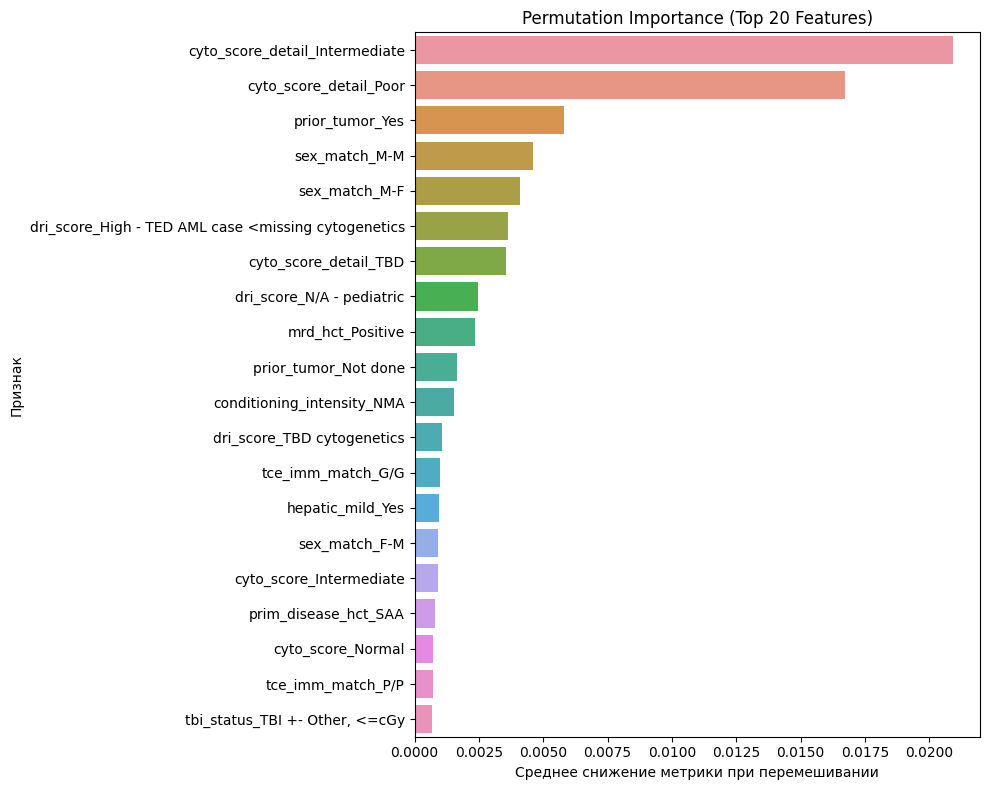

In [48]:
# Загружаем сохранённые предсказания и подготовленные данные
test_preds = pd.read_csv("test_predictions_full.csv")

# Загружаем X_test (предобработанный DataFrame с теми же признаками, что были на этапе обучения)
# Предположим, у нас он сохранён
X_test = pd.read_csv("X_test_preprocessed.csv")

# Предположим, что для оценки важности мы используем один из ранее обученных регрессоров
# Например, модель из группы 'all_features'
reg_model = manual_group_models_reg['all_features']

# Создадим маску: только те строки, по которым делались предсказания
# (т.е. у которых efs==1 в оригинале, но тут просто по наличию в test_preds['ID'])
mask = X_test['ID'].isin(test_preds['ID'])

# Обнуляем индексы, чтобы всё было синхронизировано
X_for_imp = X_test[mask].drop(columns=['ID']).reset_index(drop=True)
y_for_imp = test_preds['risk_score'].values

# Расчёт permutation importance
result = permutation_importance(
    reg_model,
    X_for_imp,
    y_for_imp,
    n_repeats=10,
    random_state=42,
    scoring='neg_mean_squared_error'
)

# Формируем датафрейм
perm_df = pd.DataFrame({
    'Feature': X_for_imp.columns,
    'Importance': result.importances_mean
}).sort_values(by='Importance', ascending=False)

# Визуализация
plt.figure(figsize=(10, 8))
sns.barplot(data=perm_df.head(20), y='Feature', x='Importance')
plt.title("Permutation Importance (Top 20 Features)")
plt.xlabel("Среднее снижение метрики при перемешивании")
plt.ylabel("Признак")
plt.tight_layout()
plt.show()


## **Шаг 13. SHAP Глобальная важность признаков (Top 20)**

 97%|=================== | 4169/4320 [00:18<00:00]       

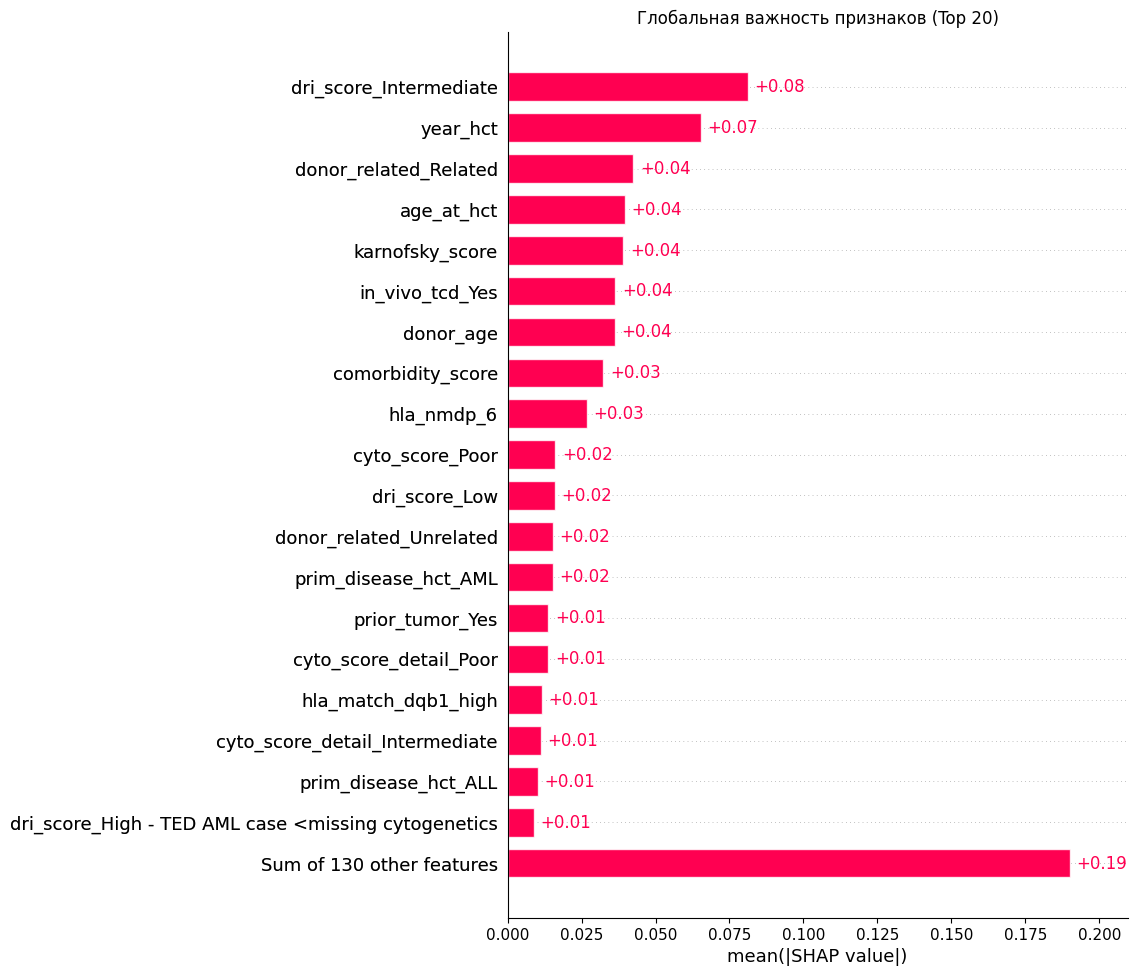

In [50]:
# SHAP-анализ
model = manual_group_models_reg['all_features']

# Назначаем индекс ID и преобразуем к float64
X_test_preprocessed.index = test['ID'].values
X_test_preprocessed = X_test_preprocessed.astype('float64')

# Объяснитель
explainer = shap.Explainer(model, X_test_preprocessed)
shap_values_global = explainer(X_test_preprocessed)

# --- Глобальная важность (bar plot) ---
plt.figure(figsize=(10, 6))
shap.plots.bar(shap_values_global, max_display=20, show=False)
plt.title("Глобальная важность признаков (Top 20)")
plt.show()


## **Шаг 14. Диагностика пациентов по ID**

In [52]:
# Пишем функцию диагностики пациентов по ID
def explain_patient(patient_id):
    global X_test_preprocessed  # используем глобальный препроцессинг

    # Проверка наличия ID
    if patient_id not in test['ID'].values:
        raise ValueError(f"Пациент с ID={patient_id} не найден в test!")

    # Получение позиции в массиве
    ix = test[test['ID'] == patient_id].index[0]
    position = test.index.get_loc(ix)

    # Предсказания
    p_event = p_event_test[position]
    pred_time = pred_time_days[position]
    risk_score = ensemble_pred_test[position]

    # Ранжирование по убыванию риска
    risk_df = pd.DataFrame({
        'ID': test['ID'].values,
        'risk_score': ensemble_pred_test
    })
    risk_df['rank'] = risk_df['risk_score'].rank(ascending=False, method='min').astype(int)
    patient_rank = risk_df[risk_df['ID'] == patient_id]['rank'].values[0]
    total_patients = len(risk_df)

    # Вывод информации
    print(f"\nПациент {patient_id}:")
    print(f"  p_event    = {p_event:.5f} (вероятность события)")
    print(f"  pred_time  = {pred_time:.2f} дней (время до события)")
    print(f"  risk_score = {risk_score:.2e} (итоговый скор риска)")
    print(f"  Ранжирование: {patient_rank}-е место из {total_patients} по риску (где 1 — наивысший риск)\n")

    # Используем объяснитель из Шага 12
    shap_values_local = explainer(X_test_preprocessed.loc[[patient_id]])
    
    # --- Индивидуальный waterfall plot ---
    plt.figure(figsize=(10, 8))
    shap.plots.waterfall(shap_values_local[0], max_display=20, show=False)
    plt.title(f"SHAP waterfall plot для пациента ID={patient_id}")
    #plt.tight_layout()
    plt.show()
    print('')

    # --- Force plot (интерактивный) ---
    shap.initjs()
    print(f"SHAP force plot для пациента ID={patient_id} (интерактивный ниже):")
    display(shap.plots.force(shap_values_local[0], matplotlib=False))



Пациент 5555:
  p_event    = 0.59927 (вероятность события)
  pred_time  = 114.74 дней (время до события)
  risk_score = 2.29e-10 (итоговый скор риска)
  Ранжирование: 4314-е место из 4320 по риску (где 1 — наивысший риск)



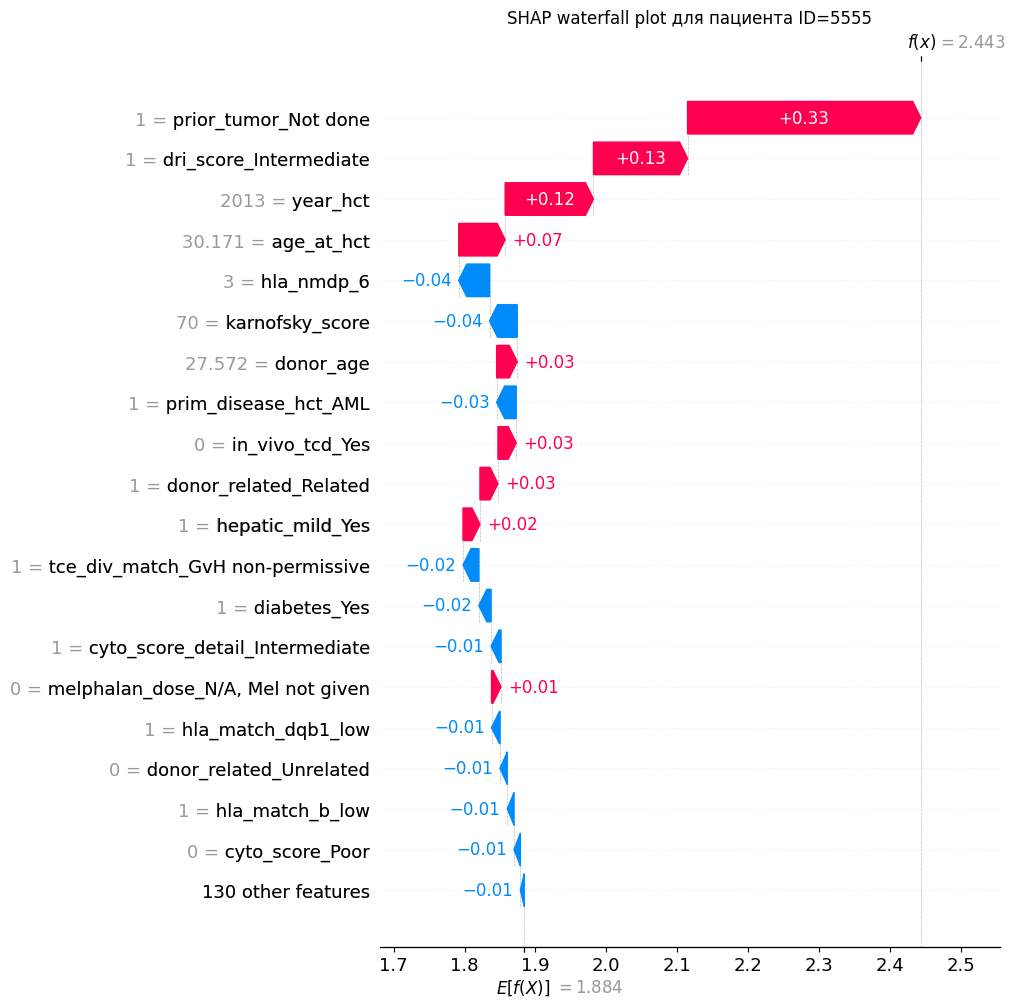

SHAP force plot для пациента ID=5555 (интерактивный ниже):


In [53]:
# Применяем функцию диагностики по ID пациента
# Примеры ID пациентов: 9012, 22905, 5555
explain_patient(5555)
